In [199]:
import sys
from pathlib import Path

# Ensure `src` directory is on sys.path so local modules (e.g., `inference`, `CNN_Transformer_Model`) are importable
# __file__ is not defined in Jupyter notebooks, so fall back to the current working directory.
try:
	base_dir = Path(__file__).resolve().parent
except NameError:
	base_dir = Path.cwd()

# If the notebook sits in a 'notebooks' folder, assume the repo root is its parent
repo_root = base_dir.parent if base_dir.name == "notebooks" else base_dir

sys.path.insert(0, str(repo_root))

In [ ]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import color
from CNN_Transformer_Model import CNNTransformerColourizer

print("CUDA Available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

CUDA Available: True
Device: cuda


In [201]:
# Path to trained model checkpoint
MODEL_PATH = r"C:\Users\ethan\Github Repositories\Image Colourisation\models\final_v1.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNTransformerColourizer().to(device)

checkpoint = torch.load(MODEL_PATH, map_location=device)
if isinstance(checkpoint, dict) and "model_state_dict" in checkpoint:
	model.load_state_dict(checkpoint["model_state_dict"])
else:
	model.load_state_dict(checkpoint)

model.eval()

print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
# Path to input image (grayscale or RGB)
IMAGE_PATH = r"C:\Users\ethan\Github Repositories\Image Colourisation\tests\sample_9.jpg"

# Load .jpg and convert to L channel normalized to [-1, 1]
L = np.array(Image.open(IMAGE_PATH)).astype("float32")
L = (L / 128) - 1.0
L = torch.tensor(L).unsqueeze(0)

print("Input image shape:", L.shape)

Input image shape: torch.Size([1, 256, 256, 3])


In [203]:
# Get prediction
with torch.no_grad():
    pred_AB = model(L_tensor)

# Apply saturation boost
SATURATION_BOOST = 1.2  # Factor to boost predicted AB values
pred_AB_boosted = pred_AB * SATURATION_BOOST
pred_AB_boosted = torch.clamp(pred_AB_boosted, -1.0, 1.0)

# Convert to numpy
L_np = L_tensor.squeeze().cpu().numpy()
pred_AB_np = pred_AB.squeeze().cpu().numpy()
pred_AB_boosted_np = pred_AB_boosted.squeeze().cpu().numpy()

# Move AB channels from shape (2, H, W) -> (H, W, 2)
pred_AB_np = np.transpose(pred_AB_np, (1, 2, 0))
pred_AB_boosted_np = np.transpose(pred_AB_boosted_np, (1, 2, 0))

# Convert back to CIELAB range
L_lab = L_np * 100.0
pred_AB_lab = pred_AB_np * 128.0
pred_AB_boosted_lab = pred_AB_boosted_np * 110.0

# Reconstruct LAB images
lab_out = np.zeros((L_lab.shape[0], L_lab.shape[1], 3))
lab_out[:, :, 0] = L_lab
lab_out[:, :, 1:] = pred_AB_lab

lab_boosted = np.zeros_like(lab_out)
lab_boosted[:, :, 0] = L_lab
lab_boosted[:, :, 1:] = pred_AB_boosted_lab

# Convert LAB → RGB
rgb_out = color.lab2rgb(lab_out)
rgb_out = (rgb_out * 255).astype(np.uint8)

rgb_boosted = color.lab2rgb(lab_boosted)
rgb_boosted = (rgb_boosted * 255).astype(np.uint8)

print("Colorized output shape:", rgb_out.shape)

Colorized output shape: (256, 256, 3)


In [204]:
# Post-processing: boost saturation and save boosted result
from PIL import ImageEnhance, Image

# Factor >1 increases saturation (1.0 = original)
SATURATION_FACTOR = 1

# Convert colorized numpy array to PIL Image and boost saturation
img_colorized = Image.fromarray(rgb_out)
enhancer = ImageEnhance.Color(img_colorized)
img_boosted = enhancer.enhance(SATURATION_FACTOR)

# Back to numpy for further processing/display
rgb_boosted = np.array(img_boosted)

# Save boosted image to repo-level results folder
output_path = repo_root / "results" / "colorized_boosted.jpg"
Path(output_path).parent.mkdir(parents=True, exist_ok=True)
img_boosted.save(output_path)
print(f"Boosted saturation by {SATURATION_FACTOR} and saved to: {output_path}")

Boosted saturation by 1 and saved to: c:\Users\ethan\Github Repositories\Image Colourisation\results\colorized_boosted.jpg


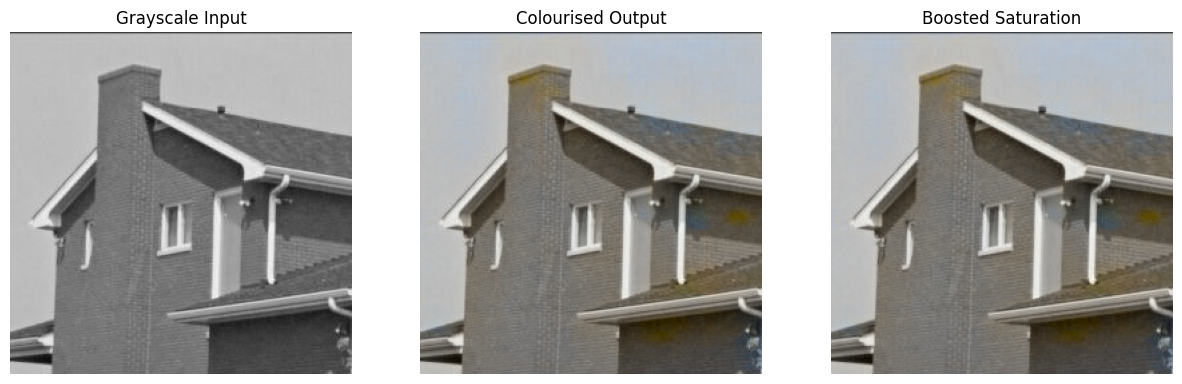

In [205]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Grayscale Input")
plt.imshow(img_np)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Colourised Output")
plt.imshow(rgb_out)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Boosted Saturation")
plt.imshow(rgb_boosted)
plt.axis("off")

plt.show()